# 2주차 과제_0310(월)

핸즈온 7장 앙상블 학습과 랜덤 포레스트 p.245- 257

## 7.1 투표 기반 분류기

**직접 투표 분류기** : 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것 (= 다수결 투표)

각 분류기가 약한 학습기(랜덤 추측보다 조금 더 높은 성능을 내는 분류기)일지라도 충분하게 많고 다양하다면 앙상블은 (높은 정확도를 내는) 강한 학습기가 될 수 있음.

In [20]:
import warnings
warnings.filterwarnings('ignore')

# import package
import numpy as np
import os

#5장에서 소개한 moons dataset 불러오기
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X,y = make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [21]:
# 여러 분류기를 조합하여 사이킷런의 투표 기반 분류기(VotingClassifier)를 만들고 훈련시키는 코드
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [22]:
# 각 분류기의 테스트셋 정확도 확인
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.9
RandomForestClassifier 0.95
SVC 0.95
VotingClassifier 0.95


**간접 투표**

모든 분류기가 클래스의 확률을 예측할 수 있으면 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측하는 것

확률이 높은 투표에 비중을 더 두기 때문에 직접 투표 방식보다 성능이 높음

voting = "soft"로 바꾸어 사용하면 됨

## 7.2 배깅과 페이스팅

<다양한 분류기 만드는 법>

1. 각기 다른 훈련 알고리즘을 사용하는 것

2. 같은 알고리즘을 사용하고 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습 시킴

- **배깅** : 훈련 세트에서 중복을 허용하여 샘플링하는 방식

- **페이스팅** : 중복을 허용하지 않고 샘플링하는 방식

모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모다서 새로운 샘플에 대한 예측을 만듬

수집 함수 : 분류의 경우 통계적 최빈값을, 회귀의 경우 평균을 이용

개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 훨씬 크게 편향되어 있지만 수집 함수를 통과하면 편향과 분산이 모두 감소함, 앙상블의 경우에는 원본 데이터셋으로 하나의 예측기를 훈련시킬 때와 비교해 편향은 비슷하지만 분산은 줄어듬

### 7.2.1 사이킷런의 배깅과 페이스팅

In [24]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,max_samples=50, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

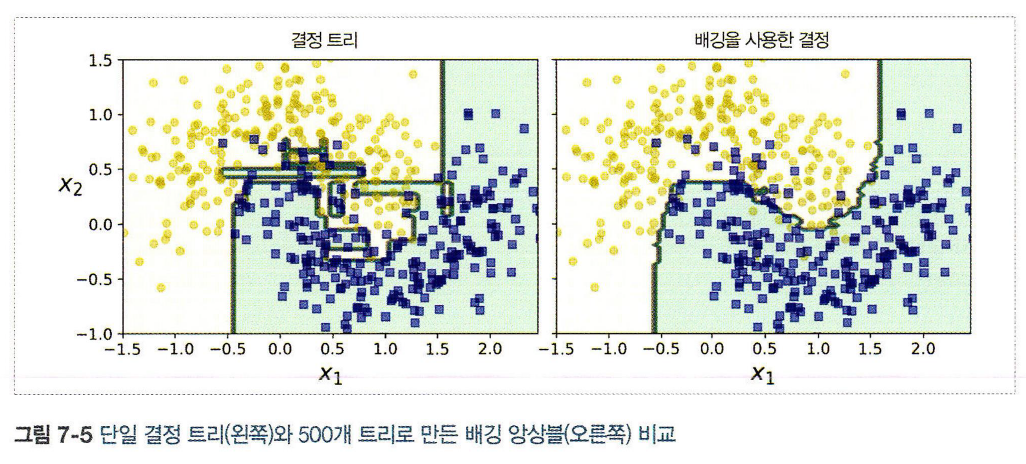

앙상블의 예측이 결정 크리 하나의 예측보다 일반화가 훨씬 잘된 것 같음

앙상블 : 비슷한 편향에서 더 작은 분산을 만듬(훈련 세트의 오차 수가 거의 비슷하지만 결정 경계는 덜 불규칙함)

부트스트래핑 : 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 배깅이 페이스팅보다 편향이 조금 더 높음, 하지만 다양성을 추가한다는 것은 예측기들의 상관관계를 줄이므로 앙상블의 분산을 감소시킴

### 7.2.2 oob 평가

배깅을 사용하면 어떤 샘플은 한 에측기를 위해 여러 번 샘플링되고 어떤 것은 전혀 선택되지 않을 수 있음

이 때 선택되지 않은 훈련 샘플의 나머지를 **oob 샘플**이라고 함(예측기마다 남겨진 oob 샘플은 다름)

예측기가 훈련되는 동안에는 oob 샘플을 사용하지 않으므로 별도의 검증 세트 없이 oob 샘플을 사용해 평가 가능

In [25]:
# oob 평가
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 500,
    bootstrap = True, oob_score = True)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9625

In [26]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.95

In [27]:
# oob 샘플에 대한 결정 함수의 값 확인
bag_clf.oob_decision_function_

array([[0.27428571, 0.72571429],
       [0.31284916, 0.68715084],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.26315789, 0.73684211],
       [0.94827586, 0.05172414],
       [0.984375  , 0.015625  ],
       [0.08648649, 0.91351351],
       [0.        , 1.        ],
       [0.40588235, 0.59411765],
       [0.        , 1.        ],
       [0.99043062, 0.00956938],
       [0.03243243, 0.96756757],
       [0.96629213, 0.03370787],
       [0.        , 1.        ],
       [0.14438503, 0.85561497],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.90052356, 0.09947644],
       [0.99453552, 0.00546448],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.83552632, 0.16447368],
       [1.        , 0.        ],
       [0.36464088, 0.63535912],
       [0.        , 1.        ],
       [0.01149425, 0.98850575],
       [0.02717391, 0.97282609],
       [0.58064516, 0.41935484],
       [0.99418605, 0.00581395],
       [0.

## 7.3 랜덤 패치와 랜덤 서브스페이스

**랜덤 패치 방식** : 훈련 특성과 샘플을 모두 샘플링 하는 것

**랜덤 서브스페이스 방식** : 훈련 샘플을 모두 사용하고 특성은 샘플링하는 것

특성 샘플링은 더 다양한 예측기를 만들며 편향을 늘리는 대신 분산을 낮춤

## 7.4 랜덤 포레스트

**랜덤 포레스트**

배깅 방법(또는 페이스팅)을 적용한 결정 트리 앙상블

max_samples를 훈련 세트의 크기로 지정

BaggingClassifier에 DecisionTreeClassifier를 넣어 만드는 대신 결정 트리에 최적화되어 사용하기 편리한 RandomForestRegressor를 사용할 수 있음

In [28]:
# 500개 트리로 이뤄진 랜덤 포레스트 분류기를 여러 CPU 코어에서 훈련시키기
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16, n_jobs = -1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

랜덤 포레스트 알고리즘은 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중 최적의 특성을 찾는 식으로 무작위성을 주입함

↪ 편향을 손해보는 대신 분산을 낮추어 전체적으로 더 훌륭한 모델은 만들어 냄

In [29]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features = "auto", max_leaf_nodes = 16),
    n_estimators = 500, max_samples = 1.0, bootstrap = True, n_jobs = -1)

### 7.4.1 엑스트라 트리

랜덤 포레스트에서 트리를 만들 때 각 노드는 무작위로 특성의 서브셋을 만들어 분할하여 사용함, 이때 트리를 더욱 무작위하게 만들기 위해 최적의 임곗값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음 그중 최상의 분할을 선택하는 극단적인 무작위한 트리의 랜덤 포레스트를 **익스트림 랜덤 트리 앙상블** 이라고 부름

### 7.4.2 특성 중요도

랜덤 포레스트의 장점 : 특성의 상대적 중요도를 측정하기 쉬움

사이킷런은 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정함

훈련이 끝난 뒤 특성마다 자동으로 이 점수를 계산하고 중요도의 전체 합이 1이 되도록 결괏값을 정규화함

In [31]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators = 500, n_jobs = -1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.09473696382396353
sepal width (cm) 0.02776029708892659
petal length (cm) 0.4480165473839034
petal width (cm) 0.42948619170320645
